## Geologic model of Gottesacker from scratch in GemPy
***
Requires two csv files, one for orientations and one for interfaces. Column headings are case-sensitive and must match the headings used by GemPy:
<br>X Y Z formation                        ---> x, y, and z should be numbers not strings, formation is the formation name string
<br>X Y Z azimuth dip polarity formation   ---> azimuth=strike in degrees, polarity=1

In [1]:
#To-do:
#figure out how to efficiently get points from a geologic map
#georeference Nico's map and get coordinates and elevations for his strike & dip measurements
#import DEM (as tif (or shx?)) and geol map (as tif (or png?)) into python, make sure they are referenced to each other, using geopandas
#if possible import Nico's map with strike  dip measurement locations -might need to georeference first in ArcMap
#enable interactive point picking using bokeh (or matplotlib?)
#set formation first, then pick points interactively and append them to the dataframe for that formation, then run function again for each formation
#add ability to create points by adding or subtracting a formation's thickness from a point on the overlying or underlying formation?
#add x-sections - how to do this? georeference the lines in ArcMap? then what?

## Imports & Setup

In [2]:
# Import packages:

import sys, os
import numpy as np
import pandas as pn
import matplotlib.pyplot as plt
import theano
import geopandas as geo
import gdal
from copy import copy


sys.path.append("../../..")   #optional: if gempy has been downloaded from GitHub rather than installed normally, look for it in the folders above the current folder
import gempy as gp

# Import local packages:
import elisa

#embed matplotlib figures into notebooks:
%matplotlib inline            

../../..\gempy\plotting\visualization.py:36: UserWarning: Steno 3D package is not installed. No 3D online visualization available.
  warnings.warn('Steno 3D package is not installed. No 3D online visualization available.')
../../..\gempy\posterior_analysis.py:24: UserWarning: pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.")
../../..\gempy\posterior_analysis.py:28: UserWarning: pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.")


575012.5 593962.5 5238037.5 5252987.5


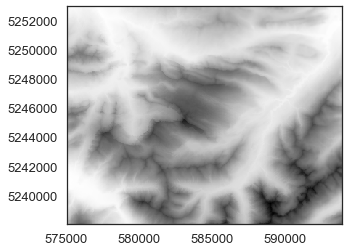

In [3]:
# Import data:

#Option 1: Import DEM from shapefile using geopandas:
#requires knowing number of cells in x and y to reshape, but doesn't require installing gdal
dem = geo.read_file('dem50.shx', enabled_drivers=['GeoJSON', 'ESRI Shapefile']) #import shapefile (must be .shx not .shp, and must have all associated files) (also note DEM=DGM, but DEM is NOT the same as DSM)
im = dem['GRID_CODE'].values.reshape(300,380)   #reshape data from x,y,z to a grid
#get extent:
xmin=dem['x'].min()                             
xmax=dem['x'].max()
ymin=dem['y'].min()
ymax=dem['y'].max()
print(xmin,xmax,ymin,ymax)
plt.imshow(im, extent=(xmin,xmax,ymin,ymax)) #plot raster as image

Min z val is equal to nan val - making a copy of the array as floats with np.nan to find true min
[ 574987  594037 5237962 5253012     791    2381] [301 381]


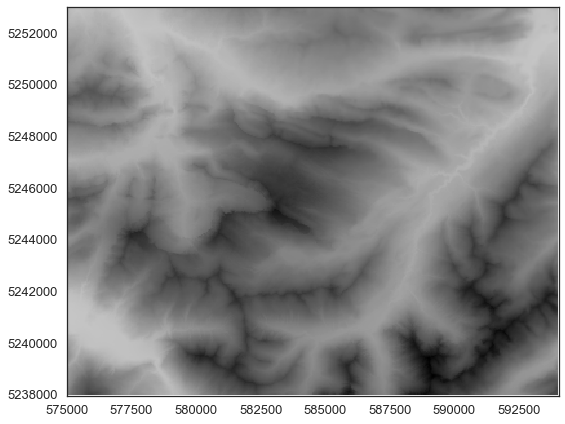

In [11]:
# Option 2:Import DEM from tif file using gdal and elisa's code:
demtif = gdal.Open('DEMraster50.tif')    #DEM must be rectangular tif 


extent, res = elisa.gdal2geodata_extent(demtif)     #get extent and resolution info from dem using gdal
print(extent, res)
xmin=extent[0]         #min x coordinate (longitude)                    
xmax=extent[1]
ymin=extent[2]         #min y coordinate (latitude)
ymax=extent[3]
zmin=extent[4]         #min z coordinate (elevation)
zmax=extent[5]
xres=res[0]            #x resolution (number of cells)
yres=res[1]
zres=50                #z resolution (from dem cell size?)
plt.imshow(demtif.ReadAsArray(), extent=(xmin,xmax,ymin,ymax)) #plot raster as image

Min z val is equal to nan val - making a copy of the array as floats with np.nan to find true min
Raster dimensions: 
xmin: 574987.5 		xmax: 594037.5 		xres: 381 
ymin: 5237962.5 	ymax: 5253012.5 	yres: 301 
zmin: 791.0 		zmax: 2199.0 		zres: 50


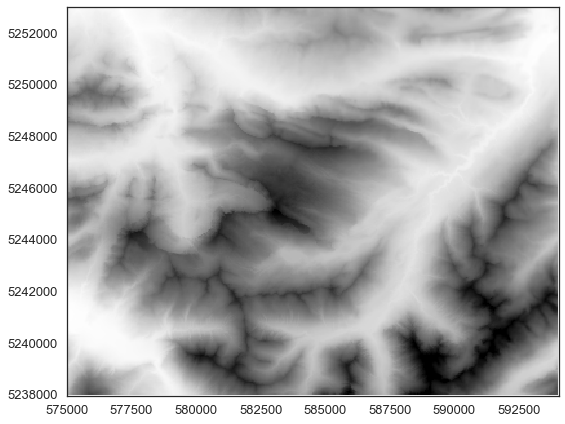

In [103]:
#Option 3: Import DEM from a tif file using gdal

dem = gdal.Open('DEMraster50.tif')    #DEM must be rectangular tif 
dema = dem.ReadAsArray()              #copy of DEM as a numpy array
nanval = 0                            #what is the numeric value assigned to nan cells in the original DEM file?

ulx, pixelwidthx, xskew, uly, yskew, pixelheighty = dem.GetGeoTransform() #get resolution and coordinate info (for some reason the order of skew and pixel size is flipped for y axis?!)
ncol = dem.RasterXSize  #number of columns (aka number of cells along x axis)
nrow = dem.RasterYSize  #number of rows (aka number of cells along y axis)
lrx = ulx + (ncol * pixelwidthx)  #lower right x coord = upper left x coord + (width of raster cells in x direction * number of raster cells in x direction)
lry = uly + (nrow * pixelheighty)

#get min and max elevations (z):
if dema.min() == nanval:  #filter if there is a numeric value for nans
    print('Min z val is equal to nan val - making a copy of the array as floats with np.nan to find true min')
    demf = dema.astype(float)       #make a copy array with floats
    demf[demf[:]==nanval]=np.nan    #replace nan vals with np.nan
    zmin = np.nanmin(demf)          #get min value excluding nans
elif dema.max() == nanval:  #filter if there is a numeric value for nans
    print('Max z val is equal to nan val - making a copy of the array as floats with np.nan to find true min')
    demf = dema.astype(float)       #make a copy array with floats
    demf[demf[:]==nanval]=np.nan    #replace nan vals with np.nan
    zmax = np.nanmax(demf)
else: 
    zmin = dema.min()             #if no nan conflicts, proceed as normal
    zmax = dema.max()                   #get max elevation

#assign useful names:
xmin = ulx
xmax = lrx
xres = ncol
ymin = lry
ymax = uly
yres = nrow
zres = 50     #how to find z resolution?

print('Raster dimensions: \nxmin: {} \t\txmax: {} \t\txres: {} \nymin: {} \tymax: {} \tyres: {} \nzmin: {} \t\tzmax: {} \t\tzres: {}'.format(xmin,xmax,xres,ymin,ymax,yres,zmin,zmax,zres))
plt.imshow(dema, extent=(xmin,xmax,ymin,ymax), vmin=zmin, vmax=zmax) #plot raster as image

In [117]:
#GK files are hand-picked data from Nico's map
#gottesacker files are quick-picked data with DEM
#geo_dat resolution does NOT have to match DEM resolution, but it helps
#lower resolution computes much faster
geo_data = gp.InputData([xmin,xmax, ymin,ymax, zmin,zmax], [xres//2,yres//2,zres],        #set x,y,z min and max extent, and x,y,z resolution (can use info from DEM but must be integers)
                       path_i='gottesacker_interfaces.csv',                     #csv file for interface points: must be at bottom of a layer, col names are case sensitive, must include at least 2 points per unit
                       path_o='gottesacker_orientations.csv')                   #csv file for orientation points: col names are case sensitive, must include at least one point per unit 

In [118]:
# View geologic info:
print(gp.get_data(geo_data, itype='formations'))   #list formations
geo_data.interfaces.head()                  #display first few rows of geo_data dataframe
#gp.plot_data(geo_data)                      #plot geo_data
#gp.plot_data_3D(geo_data)                  #plot geo_data in 3D using VTK (optional) (note: when a VTK interactive window is open, nothing else in the notebook can run - pause or close the window before continuing)

               value  formation_number
Drusberg           1                 1
Garschella         2                 2
Schrattenkalk      3                 3
fault              4                 4
basement           5                 5


,X,Y,Z,formation,series,formation_number,order_series,isFault,annotations,formation_value
24,582189.47,5246000.86,1695.0,Drusberg,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},0}$",1
25,582189.47,5246000.86,1695.0,Drusberg,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},1}$",1
1,584332.40,5244351.58,1913.0,Garschella,Default series,2,1,False,"${\bf{x}}_{\alpha \,{\bf{2}},0}$",2
2,583618.02,5244708.77,2037.0,Garschella,Default series,2,1,False,"${\bf{x}}_{\alpha \,{\bf{2}},1}$",2
3,583745.02,5245835.89,1955.0,Garschella,Default series,2,1,False,"${\bf{x}}_{\alpha \,{\bf{2}},2}$",2


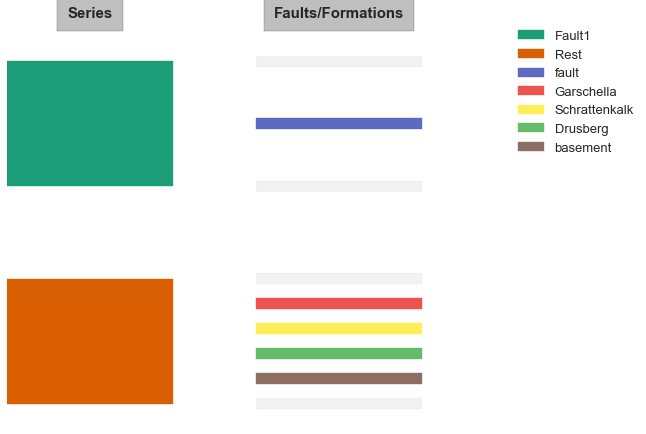

In [119]:
#Set series and formations stratigraphy for viewing:
#to-do: see how hard it would be to make colors customizable

#if using gottesacker files:
gp.set_series(geo_data, {'Fault1': 'fault',  'Rest': ['Garschella', 'Schrattenkalk', 'Drusberg']}, verbose=1)  #series indicate BOTTOM of named layer

#if using GK files:
#gp.set_series(geo_data, {'Series1': ['Amdener', 'Garschella', 'Schrattenkalk', 'Drusberg']}, verbose=1)  #series indicate BOTTOM of named layer



In [120]:
# Clean up data:
#only needed for gottesacker quick-pick data
#need to add an orientation because each series needs to have at minimum one orientation and two interfaces

gp.set_orientation_from_interfaces(geo_data, [17,18,19] )            #calculate & append an orientation from 3 or more points (preferably close together but not in a line) in one series
#the second argument is the row indices of the points to use

,X,Y,Z,G_x,G_y,G_z,dip,azimuth,polarity,formation,series,formation_number,order_series,isFault,annotations,formation_value
2,584586.93,5.247729e+06,1851.333333,-0.421298,0.516779,0.745283,41.816559,320.811737,1.0,fault,Fault1,1,1,True,"${\bf{x}}_{\beta \,{\bf{1}},0}$",1
0,587549.48,5.246858e+06,1360.000000,0.012507,0.358150,0.933580,21.000000,2.000000,1.0,Garschella,Rest,2,2,False,"${\bf{x}}_{\beta \,{\bf{2}},0}$",2
1,583644.48,5.245876e+06,1953.000000,-0.086824,0.150384,0.984808,10.000000,330.000000,1.0,Garschella,Rest,2,2,False,"${\bf{x}}_{\beta \,{\bf{2}},1}$",2


## Create model

In [121]:
# Interpolate data:
#Caution: takes a while because has to compile. 
#only have to compile once UNLESS change presence of faults or not (number of faults doesn't matter - can change the number of fms & faults afterwards)
#but have to compile after data is imported 
#if changes are made to geo_data after this step, use update_interpolator (see below)
#do you need to recompile if the resolution is changed?
#defaults to float32 - use dtype='float64' to add precision (slower)


interp_data = gp.InterpolatorData(geo_data, compile_theano=True,
                                  theano_optimizer='fast_compile', is_lith=True, is_fault=True)


Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  1


In [61]:
# Optional: if changes are made to geo_data, can update interpolation without re-compiling:
interp_data.update_interpolator(geo_data)    

In [122]:
# Optional: set faults to be finite:
inf_factor = interp_data.interpolator.tg.inf_factor.get_value()     #fault extent is controlled by an infinity factor (default=10, which is larger than model scale)
inf_factor[0]=0                                                     #set infinity factor to 0 to make faults finite
interp_data.interpolator.tg.inf_factor.set_value(np.zeros(10, dtype="int32"))   #update value 
interp_data.interpolator.tg.inf_factor.get_value()                              #display new values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [123]:
# Compute model:
lith, fault = gp.compute_model(interp_data)  #lith is two arrays (each with dim: model extent) with a formation number assigned to each cell

In [126]:
np.shape(lith[0])
print(lith[0])

[5. 5. 5. ... 2. 2. 2.]


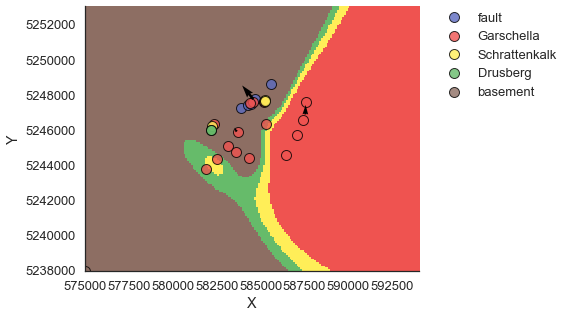

In [124]:
# Display model results:
gp.plotting.plot_section(geo_data, lith[0], 25, plot_data=True, direction='z')   #plot 2D x-sec (block must equal an array of formation numbers) 
ver, sim = gp.get_surfaces(interp_data, lith[1], fault[1])                       #create 3D objects for plotting
gp.plotting.plot_surfaces_3D_real_time(geo_data, interp_data, ver, sim)          #display in 3D with VTK
#note: this will leave this code block hanging - need to close the VTK window to continue

code works until here with gottesacker_interfaces and gottesacker_orientations files, and with resolution from DEM divided by 2 (integer division)

## Project and crop with topography

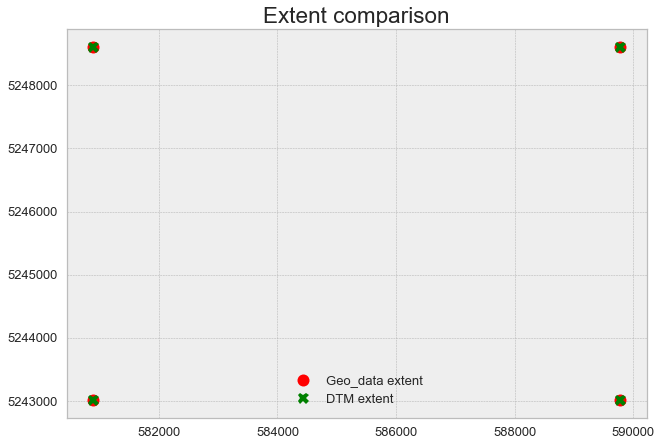

Extent of geo_data and DTM match. You may continue!


C:\Users\Chloe\Documents\GitHub\gempy\notebooks\prototype_notebooks\Chloe_Gottesacker\elisa.py:71: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  #print(shape)


array([[5.8093750e+05, 5.2485625e+06, 1.0000000e+00],
       [5.8103750e+05, 5.2485625e+06, 1.0000000e+00],
       [5.8113750e+05, 5.2485625e+06, 1.0000000e+00],
       ...,
       [5.8953750e+05, 5.2430625e+06, 1.0000000e+00],
       [5.8963750e+05, 5.2430625e+06, 1.0000000e+00],
       [5.8973750e+05, 5.2430625e+06, 1.0000000e+00]])

In [12]:
#to see this working - use DEMraster100_crop.tif for dem, and use same extent for geo_data

import gdal
hallo = gdal.Open('DEMraster100.tif')    #DEM must be tif (go back to ArcMap & export a 50m resolution square tif (NOT cropped to watershed boundaries))
extent, res = elisa.gdal2geodata_extent(hallo)
xmin=extent[0]                             
xmax=extent[1]
ymin=extent[2]
ymax=extent[3]
zmin=extent[4]
zmax=extent[5]
geo_data = gp.InputData([xmin,xmax, ymin,ymax, zmin,zmax], [89, 56, 50],        #set x,y,z min and max extent, and x,y,z resolution (can use info from DEM)
                       path_i='gottesacker_interfaces.csv',                     #csv file for interface points: must be at bottom of a layer, col names are case sensitive, must include at least 2 points per unit
                       path_o='gottesacker_orientations.csv')                   #csv file for orientation points: col names are case sensitive, must include at least one point per unit 

elisa.compare_extent(hallo, geo_data)
cropped = hallo
cropped.ReadAsArray()[cropped.ReadAsArray() == 32767] = 1000
cropped.ReadAsArray()
g = elisa.tif2xyz('xyz', cropped)
g.reshape(-1, 3)
g2 = g.reshape(-1, 3)
g2[g2[:,2] == 32767, 2] = 1
g2

In [13]:
lith2, fault2 = gp.compute_model_at(g2, interp_data)  #will need to change all following lith to lith2 etc. (for geologic map)
#be careful with overwriting 


In [14]:
g.shape

(56, 89, 3)

In [15]:
56 * 89

4984

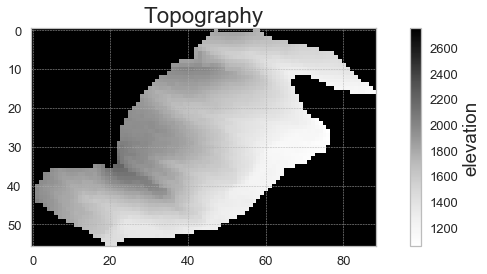

In [16]:
plt.figure(figsize=(12,4))
vdtm = plt.imshow(cropped.ReadAsArray(), vmax=2750)
plt.title("Topography")
cbar = plt.colorbar(vdtm)
cbar.set_label('elevation')

In [17]:
lb = lith[0].reshape(geo_data.resolution)

ValueError: cannot reshape array of size 4984 into shape (89,56,50)

In [25]:
89*56

4984

In [18]:
extent_dtm, res_dtm = elisa.gdal2geodata_extent(cropped)

In [19]:
dtm = cropped.ReadAsArray()
dtm[dtm==32767] = 1056

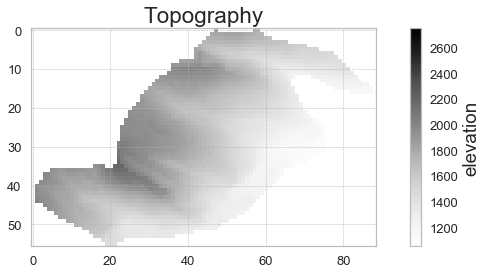

In [20]:
plt.figure(figsize=(12,4))
vdtm = plt.imshow(dtm, vmax=2750)
plt.title("Topography")
cbar = plt.colorbar(vdtm)
cbar.set_label('elevation')

In [21]:
from copy import copy
def height_ind(dtm, zs):
    '''calculate 'indices': array with shape (ext1, ext2) where the values
    are similar if the elevation is similar.'''  
    #zs = np.linspace(geo_data.extent[4], geo_data.extent[5], lb.shape[2])
    #dz = geo_data.extent[5] - geo_data.extent[4])/geo_data.resolution[2]
    # dz is number of points in z direction
    dz = (zs[-1] - zs[0]) / len(zs)
    #2. substract minimum value (here -1000) from each value of dtm and divide it by dz
    dtm_v = (dtm - zs[0]) / dz
    return dtm_v.astype(int)


def calculate_geomap(lb, dtm, geo_data, plot=True):
    zs = np.linspace(geo_data.extent[4], geo_data.extent[5], lb.shape[2])
    indices = height_ind(dtm,zs).T   
    geomap = np.zeros((lb.shape[0],lb.shape[1]))
    for x in range(lb.shape[0]):
        for y in range(lb.shape[1]):
            geomap[x,y] = lb[x,y,indices[x,y]]   
    if plot:
        plt.imshow(geomap.T, origin="upper", cmap=gp.plotting.colors.cmap, norm=gp.plotting.colors.norm)
        plt.title("Geological map")    
    return geomap.T  

def extend_lithblock(lb, factor):
    fertig2 = []
    for i in range(0,lb.shape[2]):
        lb_sub=lb[:,:,i]
        fertig = []
        for j in range(0, lb.shape[0]):
            y = np.repeat(lb_sub[j,:], factor)
            fertig = np.append(fertig, [y]*factor)
        fertig = fertig.reshape(lb.shape[0]*factor, lb.shape[1]*factor)
        fertig2.append(fertig)
        fertig2.append(fertig)
        fertig2.append(fertig)
        fertig2.append(fertig)
    return np.dstack(fertig2)

def mask_lith_block_above_topo(lb, geo_data, dtm):
    '''hier wird allen Werten die oberhalb der topographie 
    liegen ein minus eins zugewiesen und das dann maskiert'''
    zs = np.linspace(geo_data.extent[4], geo_data.extent[5], lb.shape[2])
    indices = height_ind(dtm,zs).T

    geoblock = copy(lb)
    for x in range(lb.shape[0]):
        for y in range(lb.shape[1]):
            z = indices[x,y]
            geoblock[x,y,z:] = -1
    
    return np.ma.masked_where(geoblock < 0, geoblock)

In [22]:
np.unique(height_ind(dtm,np.linspace(geo_data.extent[4], geo_data.extent[5], lb.shape[2])).T)

NameError: name 'lb' is not defined

In [23]:
geomap = calculate_geomap(lb,dtm, geo_data, plot = True)


NameError: name 'lb' is not defined

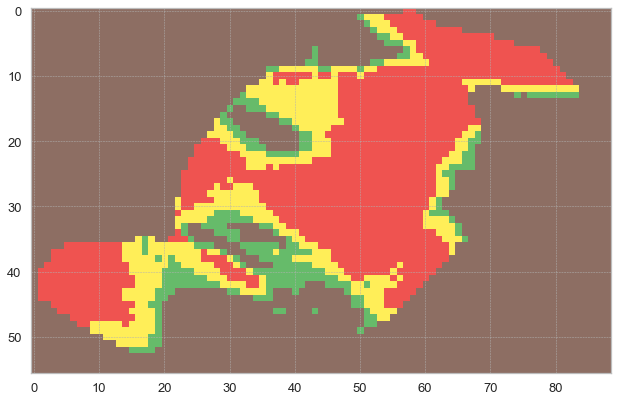

In [135]:
plt.imshow(lith[0].reshape(56, 89),  origin="upper", cmap=gp.plotting.colors.cmap, norm=gp.plotting.colors.norm)

In [96]:
dtm

array([[1056, 1056, 1056, ..., 1056, 1056, 1056],
       [1056, 1056, 1056, ..., 1056, 1056, 1056],
       [1056, 1056, 1056, ..., 1056, 1056, 1056],
       ...,
       [1056, 1056, 1056, ..., 1056, 1056, 1056],
       [1056, 1056, 1056, ..., 1056, 1056, 1056],
       [1056, 1056, 1056, ..., 1056, 1056, 1056]], dtype=int16)

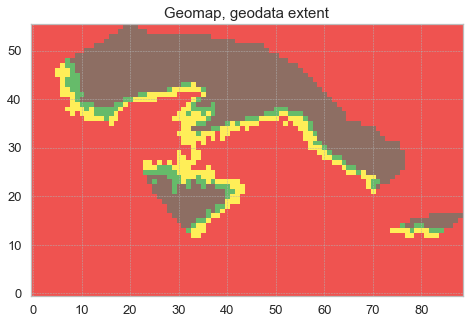

In [71]:
plt.figure(1, figsize = (10,5))
plt.imshow(geomap, origin="lower", cmap=gp.plotting.colors.cmap, norm=gp.plotting.colors.norm)
plt.title("Geomap, geodata extent", fontsize = 15)   

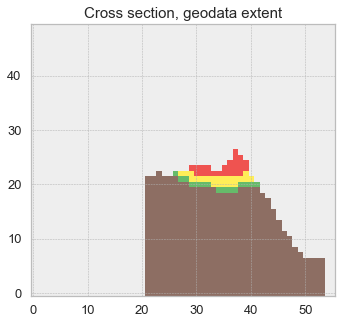

In [94]:
geoblock = mask_lith_block_above_topo(lb, geo_data, dtm)
plt.figure(1, figsize = (10,5))
fig = plt.imshow(geoblock[25,:,:].T, origin="lower", cmap=gp.plotting.colors.cmap,norm=gp.plotting.colors.norm)
plt.title("Cross section, geodata extent", fontsize = 15)  

In [73]:

lb.shape

(89, 56, 50)